In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
# Navigate to a folder in your Google Drive
os.chdir("/content/drive/MyDrive/Deep Learning/Assignment/HW5")

# List files in the folder
os.listdir()

[]

### Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [37]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from IPython.display import Image
from torchvision.utils import save_image
import os

In [38]:
fashion_mnist = FashionMNIST(root='data',
                             train=True,
                             download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 8963786.34it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 214849.68it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2981345.19it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4316728.71it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [39]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [40]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


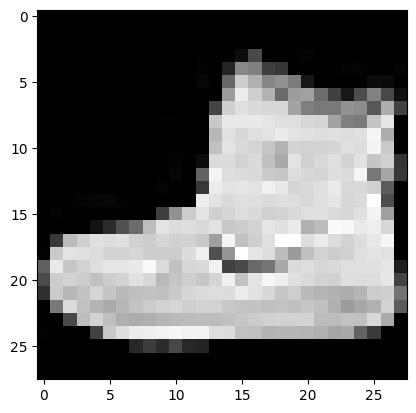

In [41]:
%matplotlib inline
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

first batch
torch.Size([100, 1, 28, 28])
tensor([7, 4, 1, 1, 3, 5, 9, 2, 7, 0, 4, 5, 2, 9, 4, 3, 6, 7, 9, 7, 1, 9, 7, 0,
        7, 4, 8, 4, 1, 6, 0, 6, 4, 9, 0, 9, 9, 6, 1, 8, 6, 4, 3, 7, 4, 5, 7, 9,
        7, 4, 0, 7, 6, 9, 6, 7, 9, 9, 9, 9, 1, 5, 9, 8, 1, 4, 4, 6, 1, 6, 2, 4,
        2, 3, 4, 0, 2, 7, 3, 3, 1, 1, 7, 4, 0, 2, 6, 6, 5, 7, 9, 8, 5, 0, 6, 2,
        3, 2, 6, 5])


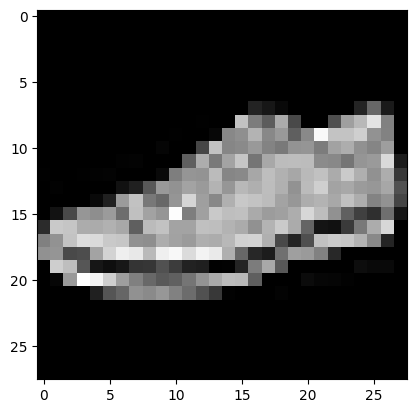

In [42]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [43]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
device

device(type='cuda')

In [45]:
latent_size = 64
image_size = 784
hidden_size = 256

In [46]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [47]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

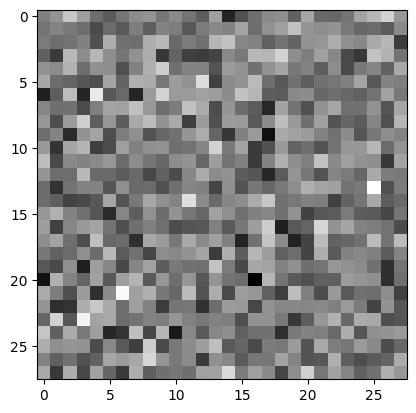

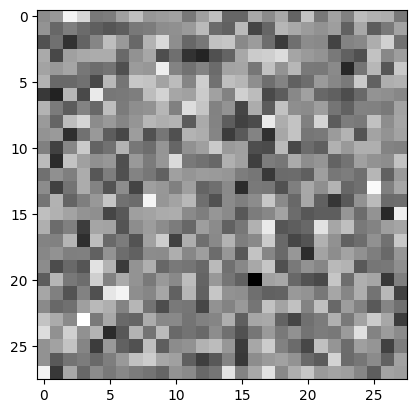

In [49]:
z = torch.randn(2, latent_size).to(device)
y = G(z)

# Denormalize and reshape the generated images
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())

# Move the tensor to the CPU before converting to numpy for visualization
gen_imgs_cpu = gen_imgs.cpu()  # Move to CPU

# Plot the generated images
plt.imshow(gen_imgs_cpu[0], cmap='gray')
plt.show()

plt.imshow(gen_imgs_cpu[1], cmap='gray')
plt.show()


### Step2. Train the GAN model to produce images in this new domain.

In [50]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [51]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [52]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [53]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

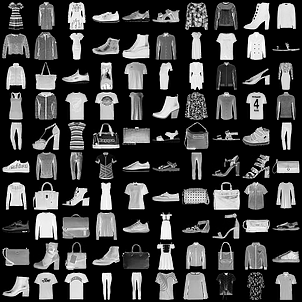

In [54]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Save real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

In [55]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)
def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)


Saving fake_images-0000.png


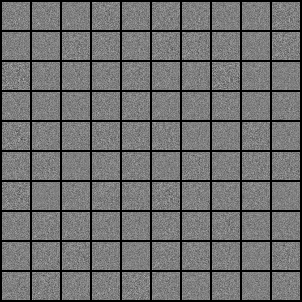

In [56]:
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [58]:
%%time
num_epochs = 150
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Flatten images into vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Save the losses and scores for later visualization
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save generated images at the end of every epoch
    save_fake_images(epoch+1)

Epoch [0/150], Step [200/600], d_loss: 0.1523, g_loss: 4.9400, D(x): 0.94, D(G(z)): 0.04
Epoch [0/150], Step [400/600], d_loss: 0.1083, g_loss: 4.9647, D(x): 0.95, D(G(z)): 0.03
Epoch [0/150], Step [600/600], d_loss: 0.1134, g_loss: 5.5417, D(x): 0.97, D(G(z)): 0.06
Saving fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.3462, g_loss: 4.3377, D(x): 0.90, D(G(z)): 0.07
Epoch [1/150], Step [400/600], d_loss: 0.2836, g_loss: 3.8163, D(x): 0.91, D(G(z)): 0.05
Epoch [1/150], Step [600/600], d_loss: 0.2884, g_loss: 4.4332, D(x): 0.88, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.1334, g_loss: 4.5782, D(x): 0.95, D(G(z)): 0.05
Epoch [2/150], Step [400/600], d_loss: 0.4665, g_loss: 3.5439, D(x): 0.90, D(G(z)): 0.13
Epoch [2/150], Step [600/600], d_loss: 0.3909, g_loss: 3.6018, D(x): 0.94, D(G(z)): 0.11
Saving fake_images-0003.png
Epoch [3/150], Step [200/600], d_loss: 0.3922, g_loss: 4.0116, D(x): 0.89, D(G(z)): 0.05
Epoch [3/150], Step [400/6

In [59]:
# Step 4: Save the model weights in the Google Drive folder
model_save_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights"

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save generator and discriminator weights
torch.save(G.state_dict(), os.path.join(model_save_dir, 'G_fashion_mnist_final.pth'))
torch.save(D.state_dict(), os.path.join(model_save_dir, 'D_fashion_mnist_final.pth'))
torch.save(G.state_dict(), os.path.join(model_save_dir, 'G_fashion_mnist.ckpt'))
torch.save(D.state_dict(), os.path.join(model_save_dir, 'D_fashion_mnist.ckpt'))

print(f'Model weights saved in {model_save_dir}')

Model weights saved in /content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights


In [60]:
d_losses_before = d_losses.copy()
g_losses_before = g_losses.copy()

In [61]:
# Step 5: Load the saved model weights from Google Drive folder

# Specify the directory where the model weights are saved
model_save_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights"

# Load the generator and discriminator weights
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist.ckpt')))
D.load_state_dict(torch.load(os.path.join(model_save_dir, 'D_fashion_mnist.ckpt')))

# Set the models to evaluation mode after loading
G.eval()
D.eval()

print("Model weights loaded successfully from Google Drive.")

Model weights loaded successfully from Google Drive.


<ipython-input-61-ee5af6f7483f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist.ckpt')))
<ipython

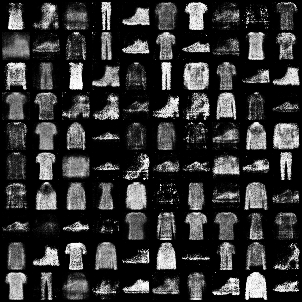

In [62]:
Image('./samples/fake_images-0100.png')

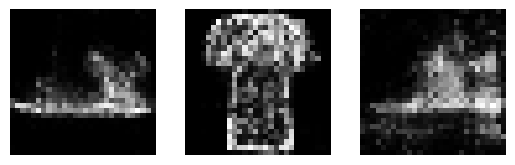

In [63]:
# Generate new images using the trained generator
def generate_and_plot_samples(G, n_samples=3):
    G.eval()  # Set generator to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        z = torch.randn(n_samples, latent_size).to(device)  # Generate latent vectors
        fake_images = G(z)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)  # Reshape to 28x28 images

    # Plot generated images
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(denorm(fake_images[i])[0].cpu(), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and display 5 samples
generate_and_plot_samples(G, n_samples=3)


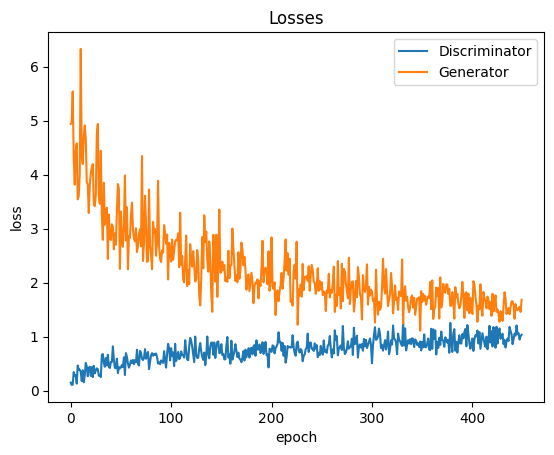

In [64]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

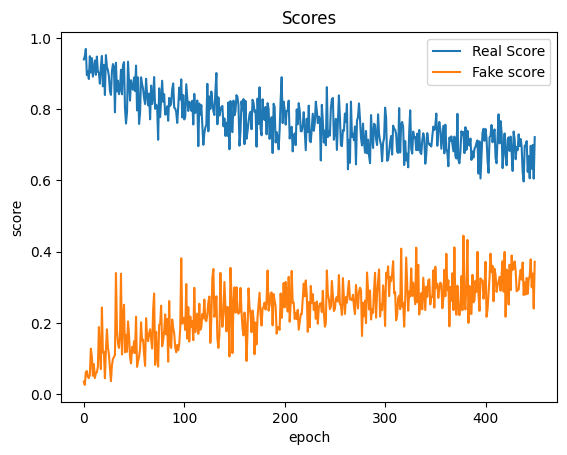

In [65]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [67]:
# Modified save_fake_images function to increment by step count instead of just epoch count
def save_fake_images(index):
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    # Save the image with sequential naming
    fake_fname = f'fake_images-{index:04d}.png'
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [68]:
%%time
num_epochs = 50  # Continue training for 50 more epochs
total_step = len(data_loader)

# Initialize lists to collect new losses and scores
d_losses_after, g_losses_after, real_scores_after, fake_scores_after = [], [], [], []

# Get the starting index from the last saved image (so that the new images are sequential)
last_image_index = get_last_image_index(sample_dir)  # Starts from the last saved index

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Flatten images into vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Save the losses and scores for later visualization
        if (i+1) % 200 == 0:
            d_losses_after.append(d_loss.item())
            g_losses_after.append(g_loss.item())
            real_scores_after.append(real_score.mean().item())
            fake_scores_after.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

            # Save generated images incrementally within each epoch
            last_image_index += 1  # Increment the image index
            save_fake_images(last_image_index)  # Save images with updated index

Epoch [0/50], Step [200/600], d_loss: 0.9433, g_loss: 1.6027, D(x): 0.67, D(G(z)): 0.30
Epoch [0/50], Step [400/600], d_loss: 0.7591, g_loss: 1.9254, D(x): 0.70, D(G(z)): 0.23
Epoch [0/50], Step [600/600], d_loss: 1.0763, g_loss: 1.2223, D(x): 0.67, D(G(z)): 0.37
Saving fake_images-0151.png
Epoch [1/50], Step [200/600], d_loss: 1.0477, g_loss: 1.3663, D(x): 0.63, D(G(z)): 0.32
Epoch [1/50], Step [400/600], d_loss: 0.9270, g_loss: 1.3803, D(x): 0.70, D(G(z)): 0.33
Epoch [1/50], Step [600/600], d_loss: 1.3420, g_loss: 1.0924, D(x): 0.60, D(G(z)): 0.41
Saving fake_images-0153.png
Epoch [2/50], Step [200/600], d_loss: 0.7842, g_loss: 1.7262, D(x): 0.74, D(G(z)): 0.27
Epoch [2/50], Step [400/600], d_loss: 0.9977, g_loss: 1.7797, D(x): 0.63, D(G(z)): 0.29
Epoch [2/50], Step [600/600], d_loss: 1.4474, g_loss: 1.3363, D(x): 0.60, D(G(z)): 0.42
Saving fake_images-0156.png
Epoch [3/50], Step [200/600], d_loss: 0.9383, g_loss: 1.5565, D(x): 0.73, D(G(z)): 0.34
Epoch [3/50], Step [400/600], d_loss

In [69]:
# Step 7: Save the model weights in Google Drive without using checkpoints

# Define the path where you want to save the model in Google Drive
model_save_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights"

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save the generator and discriminator weights
torch.save(G.state_dict(), os.path.join(model_save_dir, 'G_fashion_mnist_no_checkpoint.pth'))
torch.save(D.state_dict(), os.path.join(model_save_dir, 'D_fashion_mnist_no_checkpoint.pth'))

print(f"Model weights saved without checkpoints in {model_save_dir}")

Model weights saved without checkpoints in /content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights


In [70]:
# Step 8: Load the model weights from Google Drive without using checkpoints
# Define the directory where the model weights are stored
model_save_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights"

# Load the generator and discriminator weights from Google Drive
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_no_checkpoint.pth')))
D.load_state_dict(torch.load(os.path.join(model_save_dir, 'D_fashion_mnist_no_checkpoint.pth')))

# Set the models to evaluation mode if needed for inference
G.eval()
D.eval()

print("Model weights loaded from Google Drive without checkpoints.")

Model weights loaded from Google Drive without checkpoints.


<ipython-input-70-98930229e7a9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_no_checkpoint.pth

In [71]:
d_losses_after = d_losses.copy()
g_losses_after = g_losses.copy()

<ipython-input-72-47ae791f339e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_final.pth')))


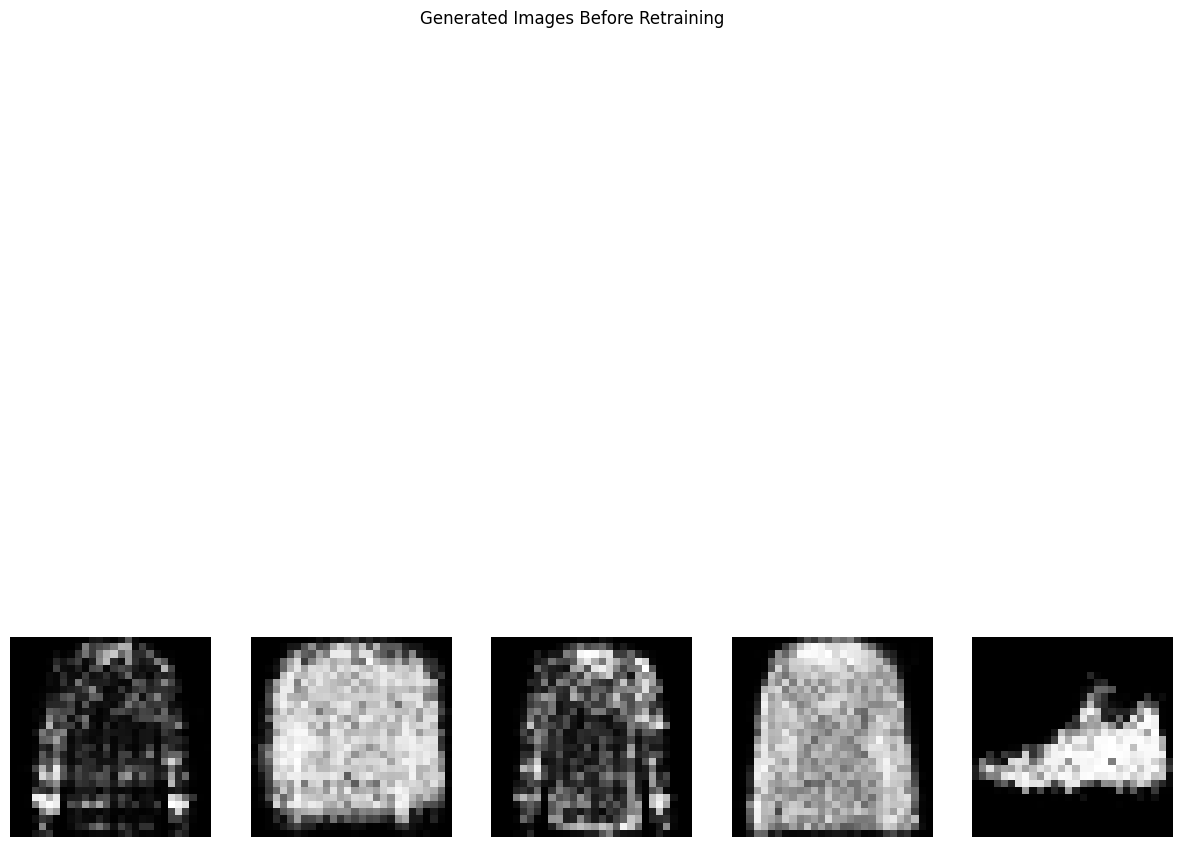

In [72]:
# Load the model weights before retraining (Step 5)
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_final.pth')))
G.eval()

# Function to generate and display images
def generate_and_plot_samples(generator, title, num_samples=5):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_samples, latent_size).to(device)  # Random latent vector
        fake_images = generator(z)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)  # Reshape to 28x28

    # Plot generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        axes[i].imshow(denorm(fake_images[i])[0].cpu(), cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Generate samples before additional training
generate_and_plot_samples(G, "Generated Images Before Retraining")


<ipython-input-73-51bb77ed0e5a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_no_checkpoint.pth

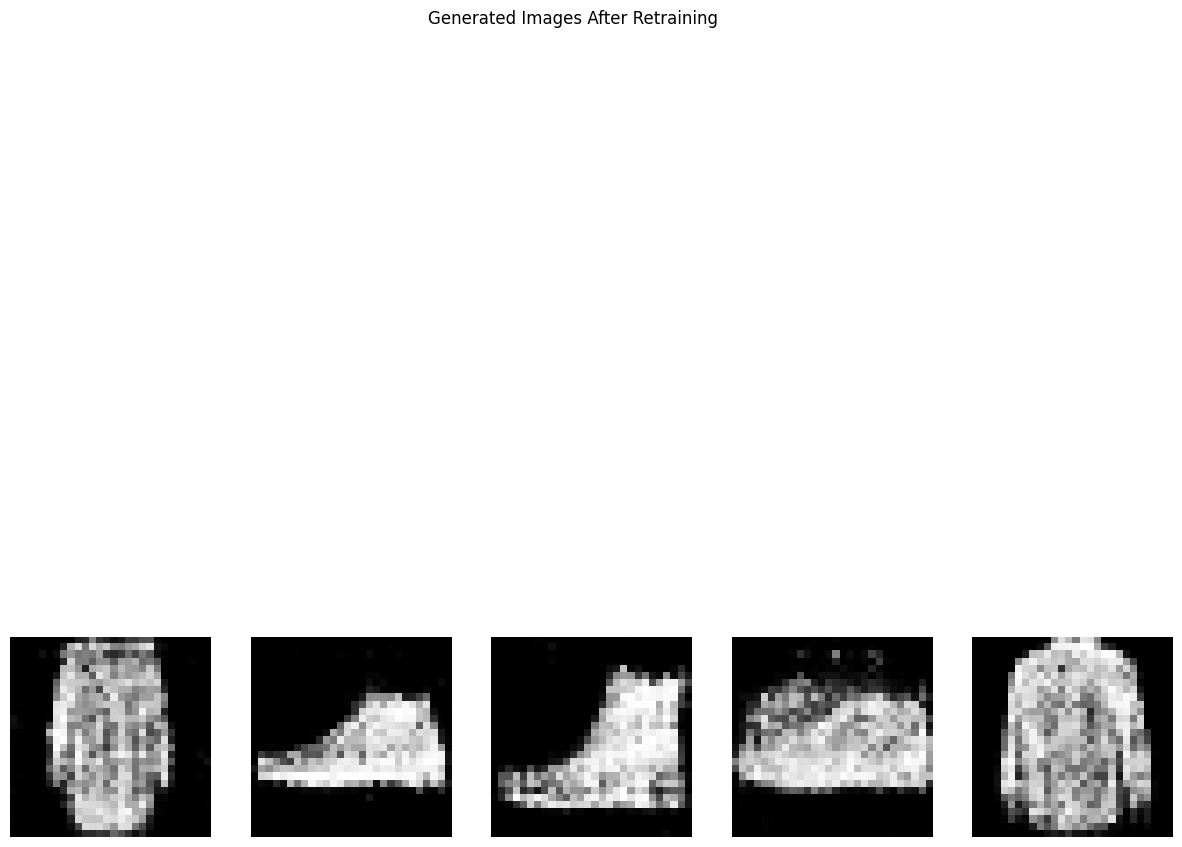

In [73]:
# Load the model weights after retraining (Step 8)
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_fashion_mnist_no_checkpoint.pth')))
G.eval()

# Generate samples after additional training
generate_and_plot_samples(G, "Generated Images After Retraining")


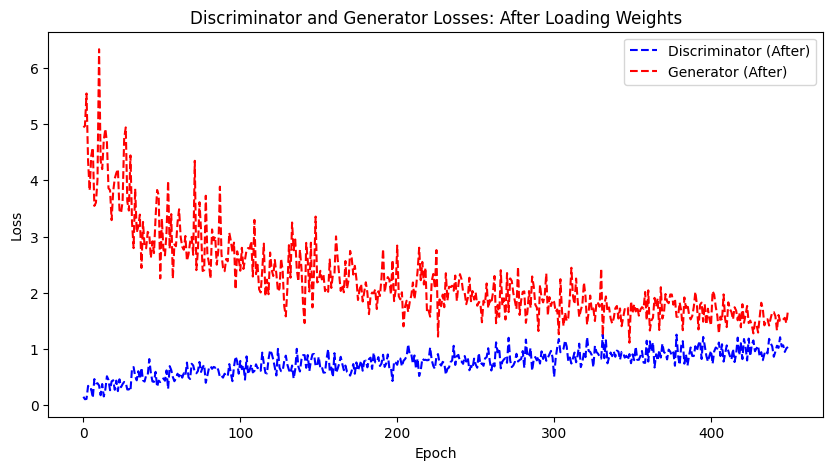

In [76]:
# Plot discriminator and generator losses after loading weights
plt.figure(figsize=(10, 5))

# Plot losses after loading weights
plt.plot(d_losses_after, 'b--', label='Discriminator (After)')
plt.plot(g_losses_after, 'r--', label='Generator (After)')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses: After Loading Weights')
plt.legend()
plt.show()


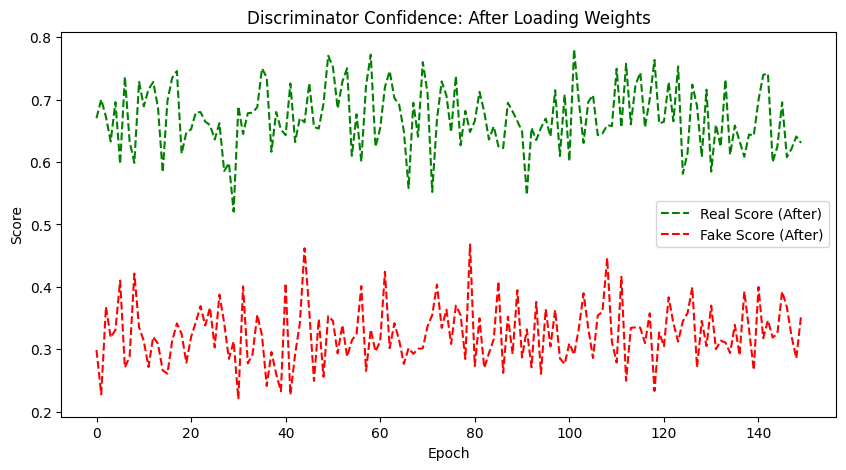

In [77]:
# Plot real and fake scores from the discriminator before and after retraining
plt.figure(figsize=(10, 5))

# Plot real and fake scores after loading weights
plt.plot(real_scores_after, 'g--', label='Real Score (After)')
plt.plot(fake_scores_after, 'r--', label='Fake Score (After)')

# Add labels, title, and legend
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Discriminator Confidence: After Loading Weights')
plt.legend()
plt.show()

In [83]:
import os
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.utils import save_image
import torch.nn as nn



In [79]:
# Set directories (no need to mount again since it's already done)
base_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5"
image_dir = os.path.join(base_dir, "Sample_lsgan")  # Directory to save generated images
weights_dir = os.path.join(base_dir, "ls_modelweights")  # Directory to save model weights

# Create directories if they don't exist
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

# Load the Fashion MNIST dataset
fashion_mnist = FashionMNIST(root='data', train=True, download=True,
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size=batch_size, shuffle=True)

print("Step 1: Loaded Fashion MNIST Dataset")

Step 1: Loaded Fashion MNIST Dataset


In [81]:
latent_size = 64
image_size = 784  # 28x28 images
hidden_size = 256

# Discriminator for LSGAN
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
)

# Generator for LSGAN
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G.to(device)
D.to(device)

# Least Squares Loss Functions
def real_loss(predictions):
    return 0.5 * torch.mean((predictions - 1) ** 2)

def fake_loss(predictions):
    return 0.5 * torch.mean(predictions ** 2)

print("Step 2: Defined the LSGAN Model")

Step 2: Defined the LSGAN Model


In [84]:
# Optimizers
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Train Discriminator
def train_discriminator(images):
    # Real images
    real_outputs = D(images)
    d_loss_real = real_loss(real_outputs)  # Least squares loss for real images
    real_score = real_outputs.detach()  # Save real scores for monitoring

    # Fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images)
    d_loss_fake = fake_loss(fake_outputs)  # Least squares loss for fake images
    fake_score = fake_outputs.detach()  # Save fake scores for monitoring

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

# Train Generator
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = real_loss(outputs)  # Generator tries to make fake images look real (D outputs close to 1)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss

In [86]:
num_epochs = 100
total_step = len(data_loader)

# Initialize lists to collect losses and scores
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Fixed random vectors for generating consistent samples
sample_vectors = torch.randn(batch_size, latent_size).to(device)

# Initialize an image index to track generated images across epochs
image_index = 0

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Flatten images into vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss = train_generator()

        # Save the losses and scores for later visualization
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())  # Average real score
            fake_scores.append(fake_score.mean().item())  # Average fake score
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save generated images at the end of each epoch
    fake_images = G(sample_vectors).reshape(batch_size, 1, 28, 28)

    # Save one image (batch of images) for each epoch
    save_image(denorm(fake_images), os.path.join(image_dir, f'fake_images_lsgan_epoch_{epoch+1:03d}.png'), nrow=10)
    print(f"Saved generated images for epoch {epoch+1}: fake_images_lsgan_epoch_{epoch+1:03d}.png")

    # Increment the image index
    image_index += 1

print("Step 3: Trained LSGAN and saved images.")

Epoch [0/100], Step [200/600], d_loss: 0.0047, g_loss: 0.5875, D(x): 0.97, D(G(z)): 0.02
Saved generated images: fake_images_lsgan_0000.png
Epoch [0/100], Step [400/600], d_loss: 0.0022, g_loss: 0.5460, D(x): 1.00, D(G(z)): -0.01
Saved generated images: fake_images_lsgan_0001.png
Epoch [0/100], Step [600/600], d_loss: 0.0023, g_loss: 0.5489, D(x): 1.00, D(G(z)): 0.02
Saved generated images: fake_images_lsgan_0002.png
Epoch [1/100], Step [200/600], d_loss: 0.0044, g_loss: 0.5774, D(x): 1.01, D(G(z)): 0.03
Saved generated images: fake_images_lsgan_0003.png
Epoch [1/100], Step [400/600], d_loss: 0.0064, g_loss: 0.6087, D(x): 0.98, D(G(z)): 0.03
Saved generated images: fake_images_lsgan_0004.png
Epoch [1/100], Step [600/600], d_loss: 0.0042, g_loss: 0.5482, D(x): 0.99, D(G(z)): 0.02
Saved generated images: fake_images_lsgan_0005.png
Epoch [2/100], Step [200/600], d_loss: 0.0161, g_loss: 0.5625, D(x): 0.93, D(G(z)): -0.04
Saved generated images: fake_images_lsgan_0006.png
Epoch [2/100], Ste

In [87]:
# Save generator and discriminator weights for LSGAN
torch.save(G.state_dict(), os.path.join(weights_dir, 'G_lsgan.pth'))
torch.save(D.state_dict(), os.path.join(weights_dir, 'D_lsgan.pth'))

print("Step 4: Saved LSGAN model weights in Google Drive.")

Step 4: Saved LSGAN model weights in Google Drive.


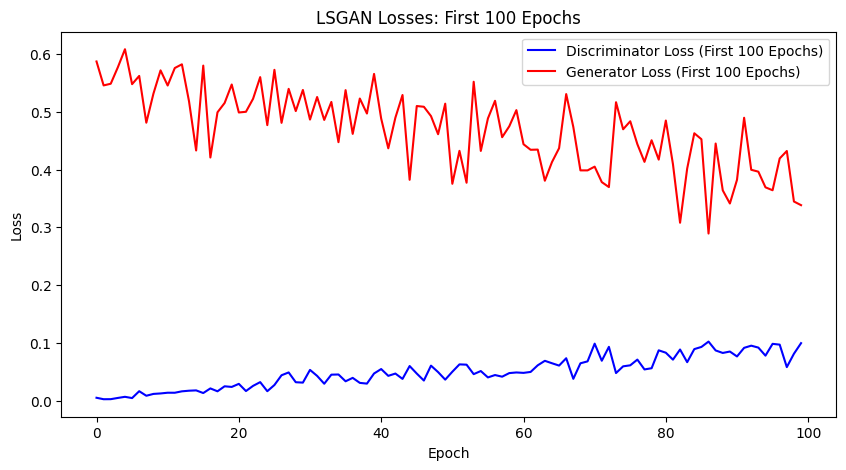

In [97]:
import matplotlib.pyplot as plt

# Plot Generator and Discriminator Losses after first 100 epochs
plt.figure(figsize=(10, 5))
plt.plot(d_losses[:100], 'b-', label='Discriminator Loss (First 100 Epochs)')
plt.plot(g_losses[:100], 'r-', label='Generator Loss (First 100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSGAN Losses: First 100 Epochs')
plt.legend()
plt.show()

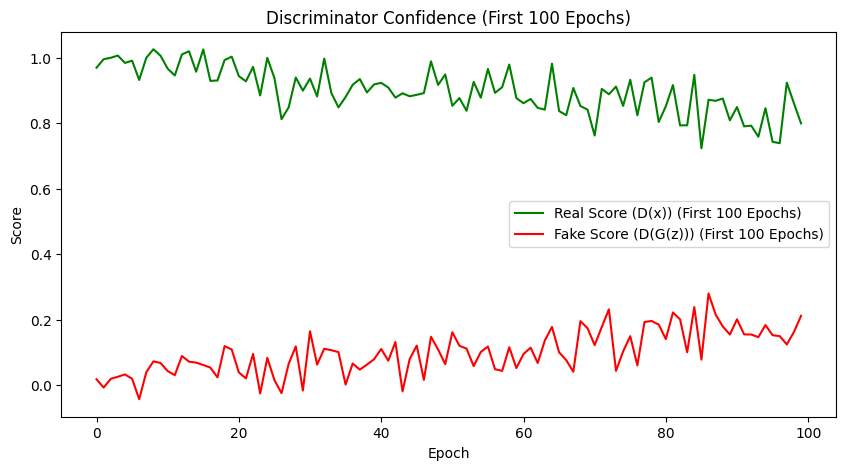

Displayed losses and scores for the first 100 epochs.


In [98]:
# Plot Real and Fake Scores from the Discriminator after first 100 epochs
plt.figure(figsize=(10, 5))
plt.plot(real_scores[:100], 'g-', label='Real Score (D(x)) (First 100 Epochs)')
plt.plot(fake_scores[:100], 'r-', label='Fake Score (D(G(z))) (First 100 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Discriminator Confidence (First 100 Epochs)')
plt.legend()
plt.show()

print("Displayed losses and scores for the first 100 epochs.")


In [100]:
# Load the trained LSGAN generator (before retraining)
G.load_state_dict(torch.load(os.path.join(weights_dir, 'G_lsgan.pth')))
G.eval()

# Function to generate and save images from the trained generator
def generate_and_save_samples(G, image_dir, n_samples=3, prefix='trained'):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_size).to(device)
        fake_images = G(z)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

    # Save generated images
    for i in range(n_samples):
        img_path = os.path.join(image_dir, f'{prefix}_fake_images_lsgan_{i:04d}.png')
        save_image(denorm(fake_images[i]), img_path)
        print(f"Saved trained model image: {img_path}")

# Save images before retraining
generate_and_save_samples(G, image_dir, n_samples=3, prefix='trained')


Saved trained model image: /content/drive/MyDrive/Deep Learning/Assignment/HW5/Sample_lsgan/trained_fake_images_lsgan_0000.png
Saved trained model image: /content/drive/MyDrive/Deep Learning/Assignment/HW5/Sample_lsgan/trained_fake_images_lsgan_0001.png
Saved trained model image: /content/drive/MyDrive/Deep Learning/Assignment/HW5/Sample_lsgan/trained_fake_images_lsgan_0002.png


<ipython-input-100-16e9e4650b71>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(weights_dir, 'G_lsgan.pth')))


In [101]:
# Load the generator and discriminator weights for LSGAN from Google Drive
G.load_state_dict(torch.load(os.path.join(weights_dir, 'G_lsgan.pth')))
D.load_state_dict(torch.load(os.path.join(weights_dir, 'D_lsgan.pth')))

# Set models to evaluation mode after loading weights
G.eval()
D.eval()

print("Step 5: Loaded LSGAN model weights from Google Drive.")

Step 5: Loaded LSGAN model weights from Google Drive.


<ipython-input-101-75548c4b1f80>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(weights_dir, 'G_lsgan.pth')))
<ipython-input-101-

In [104]:
# Retrain LSGAN for an additional 50 epochs
additional_epochs = 50  # Number of additional epochs for retraining
total_step = len(data_loader)

# Initialize lists to collect losses and scores during retraining
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

# Initialize the image index to continue from the last saved image
image_index = len(os.listdir(image_dir))  # Assuming this directory only contains images

# Continue training the LSGAN model for additional epochs
for epoch in range(additional_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Flatten images into vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss = train_generator()

        # Save the losses and scores for visualization
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{additional_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save generated images at the end of each epoch
    sample_vectors = torch.randn(batch_size, latent_size).to(device)  # Generate random latent vectors
    fake_images = G(sample_vectors).reshape(batch_size, 1, 28, 28)

    # Save one image for each epoch (sequential naming)
    save_image(denorm(fake_images), os.path.join(image_dir, f'fake_images_retrained_epoch_{image_index:03d}.png'), nrow=10)
    print(f"Saved generated images for epoch {image_index}: fake_images_retrained_epoch_{image_index:03d}.png")

    # Increment the image index to continue naming
    image_index += 1

print("Retrained LSGAN for additional epochs and saved updated weights.")

Epoch [0/50], Step [200/600], d_loss: 0.1258, g_loss: 0.2890, D(x): 0.82, D(G(z)): 0.30
Epoch [0/50], Step [400/600], d_loss: 0.1712, g_loss: 0.2448, D(x): 0.72, D(G(z)): 0.39
Epoch [0/50], Step [600/600], d_loss: 0.1180, g_loss: 0.3415, D(x): 0.75, D(G(z)): 0.20
Saved generated images for epoch 303: fake_images_retrained_epoch_303.png
Epoch [1/50], Step [200/600], d_loss: 0.1239, g_loss: 0.3208, D(x): 0.78, D(G(z)): 0.24
Epoch [1/50], Step [400/600], d_loss: 0.1157, g_loss: 0.3112, D(x): 0.80, D(G(z)): 0.20
Epoch [1/50], Step [600/600], d_loss: 0.1895, g_loss: 0.2329, D(x): 0.71, D(G(z)): 0.38
Saved generated images for epoch 304: fake_images_retrained_epoch_304.png
Epoch [2/50], Step [200/600], d_loss: 0.1495, g_loss: 0.2775, D(x): 0.65, D(G(z)): 0.29
Epoch [2/50], Step [400/600], d_loss: 0.0866, g_loss: 0.3058, D(x): 0.86, D(G(z)): 0.21
Epoch [2/50], Step [600/600], d_loss: 0.1469, g_loss: 0.2889, D(x): 0.82, D(G(z)): 0.37
Saved generated images for epoch 305: fake_images_retrained_

In [113]:
# Step 4: Save the model weights in the Google Drive folder
model_save_dir = "/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights"

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Save updated model weights after retraining in the correct directory (model_save_dir)
torch.save(G.state_dict(), os.path.join(model_save_dir, 'G_lsgan_retrained.pth'))
torch.save(D.state_dict(), os.path.join(model_save_dir, 'D_lsgan_retrained.pth'))

print(f'Model weights saved in {model_save_dir}')

Model weights saved in /content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights


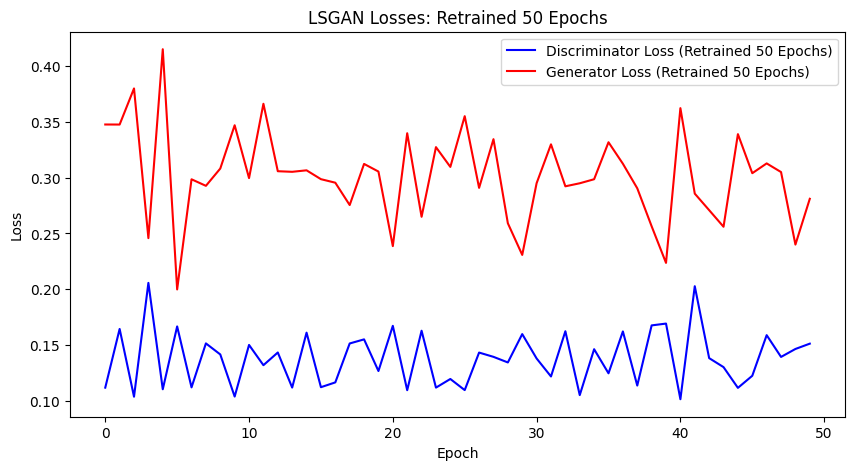

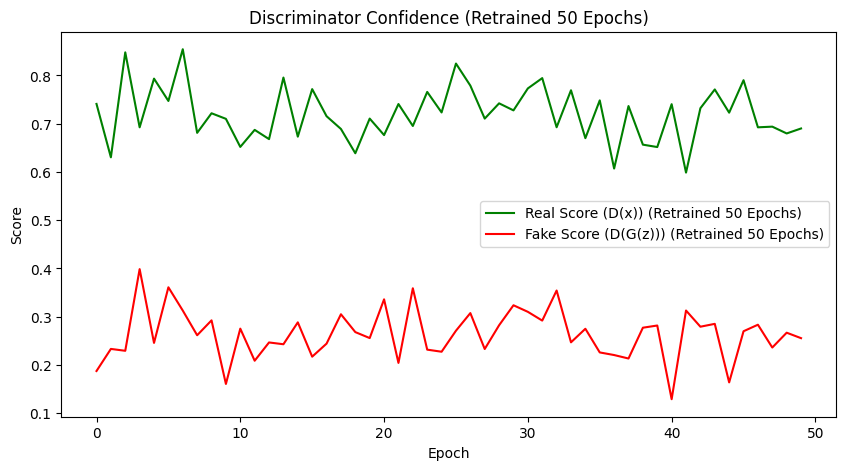

Displayed losses and scores for the additional 50 retraining epochs.


In [110]:
# Plot Generator and Discriminator Losses after retraining (next 50 epochs)
plt.figure(figsize=(10, 5))
plt.plot(d_losses[100:], 'b-', label='Discriminator Loss (Retrained 50 Epochs)')
plt.plot(g_losses[100:], 'r-', label='Generator Loss (Retrained 50 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSGAN Losses: Retrained 50 Epochs')
plt.legend()
plt.show()

# Plot Real and Fake Scores from the Discriminator after retraining (next 50 epochs)
plt.figure(figsize=(10, 5))
plt.plot(real_scores[100:], 'g-', label='Real Score (D(x)) (Retrained 50 Epochs)')
plt.plot(fake_scores[100:], 'r-', label='Fake Score (D(G(z))) (Retrained 50 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Discriminator Confidence (Retrained 50 Epochs)')
plt.legend()
plt.show()

print("Displayed losses and scores for the additional 50 retraining epochs.")

<ipython-input-114-e19cc3840fcc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_lsgan.pth')))


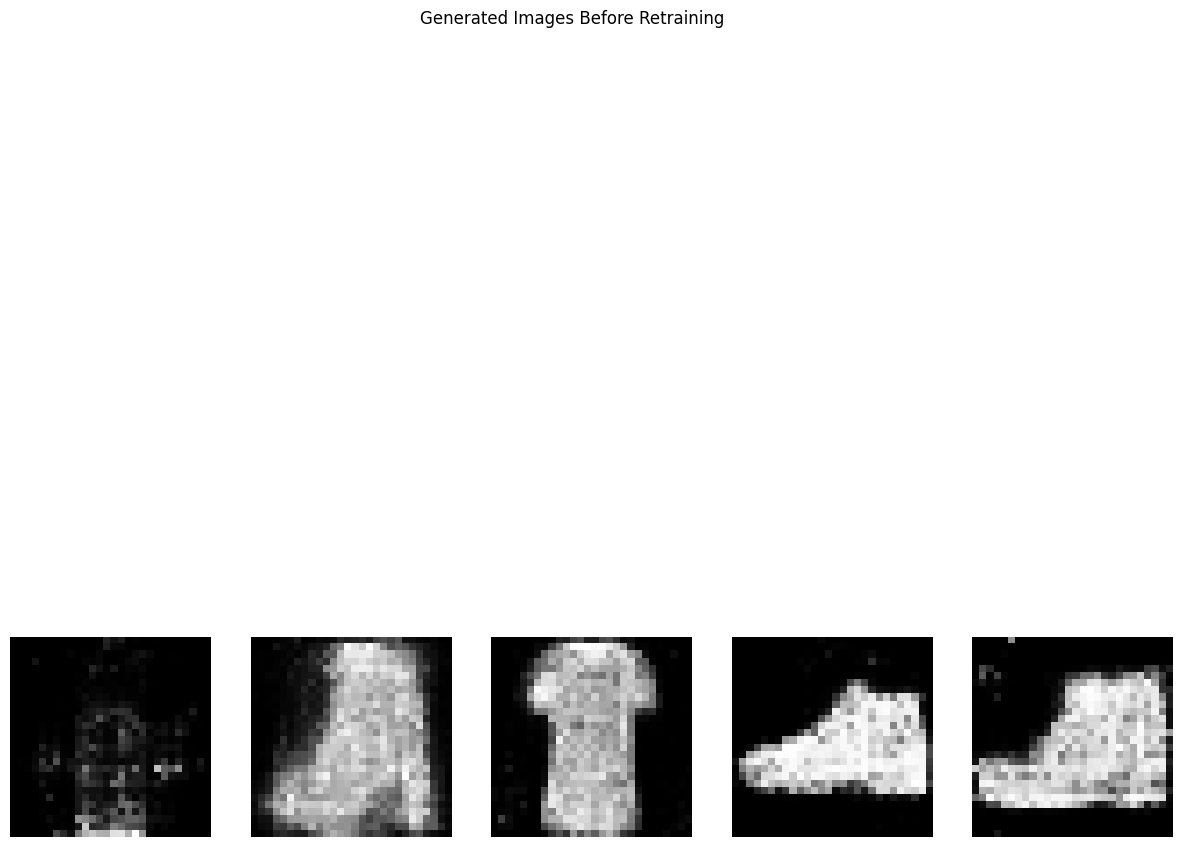

In [114]:
# Load the model weights before retraining (Step 5)
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_lsgan.pth')))
G.eval()

# Function to generate and display images
def generate_and_plot_samples(generator, title, num_samples=5):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_samples, latent_size).to(device)  # Random latent vector
        fake_images = generator(z)
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)  # Reshape to 28x28

    # Plot generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        axes[i].imshow(denorm(fake_images[i])[0].cpu(), cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Generate samples before additional training
generate_and_plot_samples(G, "Generated Images Before Retraining")


<ipython-input-115-25739cab0263>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_lsgan_retrained.pth')))


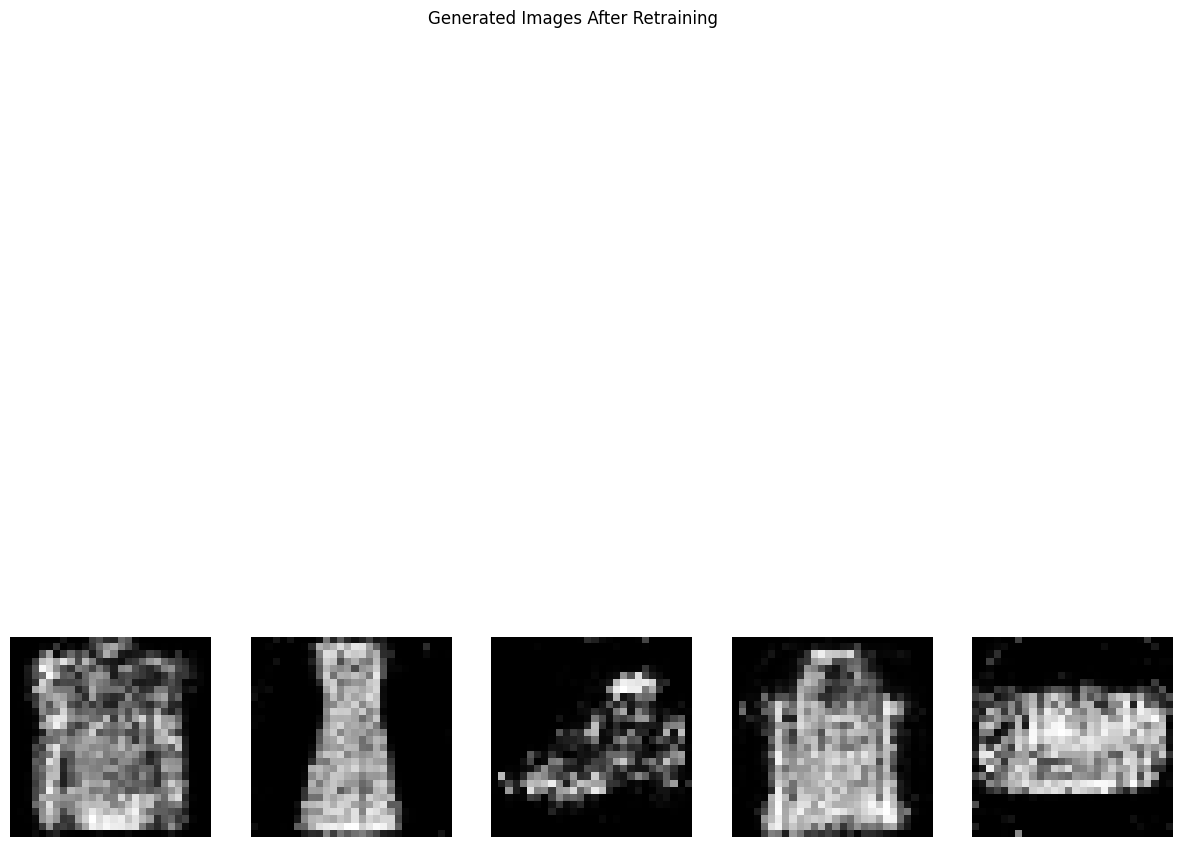

In [115]:
# Load the model weights after retraining (Step 8)
G.load_state_dict(torch.load(os.path.join(model_save_dir, 'G_lsgan_retrained.pth')))
G.eval()

# Generate samples after additional training
generate_and_plot_samples(G, "Generated Images After Retraining")


In [117]:
# Define the same GAN model architectures used for GAN training
gan_G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

gan_D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
).to(device)

# Load the saved weights for GAN models
gan_G.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights/G_fashion_mnist_no_checkpoint.pth"))
gan_D.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/model_weights/D_fashion_mnist_no_checkpoint.pth"))

gan_G.eval()
gan_D.eval()


<ipython-input-117-aad8a7bb31b8>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gan_G.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/mode

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [118]:
# Define the same LSGAN model architectures used for LSGAN training
ls_G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

ls_D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
).to(device)

# Load the saved weights for LSGAN models
ls_G.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights/G_lsgan_retrained.pth"))
ls_D.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights/D_lsgan_retrained.pth"))

ls_G.eval()
ls_D.eval()


<ipython-input-118-efd02868c214>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ls_G.load_state_dict(torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_mo

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
)

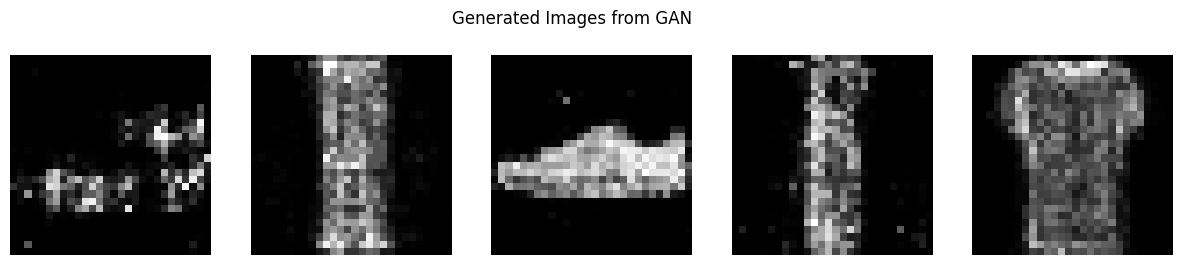

In [119]:
# Generate random latent vectors (same as used during training)
z_gan = torch.randn(batch_size, latent_size).to(device)

# Generate images using the GAN generator
gan_generated_images = gan_G(z_gan).reshape(batch_size, 1, 28, 28).detach().cpu()

# Plot and display some of the generated images from GAN
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(gan_generated_images[i][0], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Generated Images from GAN')
plt.show()


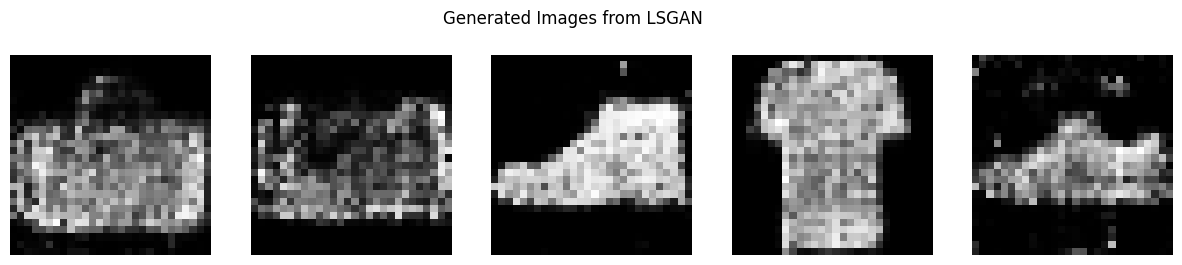

In [120]:
# Generate random latent vectors (same as used during training)
z_ls_gan = torch.randn(batch_size, latent_size).to(device)

# Generate images using the LSGAN generator
ls_gan_generated_images = ls_G(z_ls_gan).reshape(batch_size, 1, 28, 28).detach().cpu()

# Plot and display some of the generated images from LSGAN
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(ls_gan_generated_images[i][0], cmap='gray')
    axes[i].axis('off')

plt.suptitle('Generated Images from LSGAN')
plt.show()


In [ ]:
# Load saved losses for GAN (if available)
gan_d_losses = torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/gan/d_losses_gan.pth")
gan_g_losses = torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/gan/g_losses_gan.pth")

# Load saved losses for LSGAN (if available)
ls_d_losses = torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights/d_losses_lsgan.pth")
ls_g_losses = torch.load("/content/drive/MyDrive/Deep Learning/Assignment/HW5/ls_modelweights/g_losses_lsgan.pth")

# Plot Discriminator Losses
plt.figure(figsize=(10, 5))
plt.plot(gan_d_losses, 'b-', label='Discriminator Loss (GAN)')
plt.plot(ls_d_losses, 'b--', label='Discriminator Loss (LSGAN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss: GAN vs LSGAN')
plt.legend()
plt.show()

# Plot Generator Losses
plt.figure(figsize=(10, 5))
plt.plot(gan_g_losses, 'r-', label='Generator Loss (GAN)')
plt.plot(ls_g_losses, 'r--', label='Generator Loss (LSGAN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss: GAN vs LSGAN')
plt.legend()
plt.show()
